## Feature Selection Methods: 
- Variance Threshold
- L1 Regularization (Lasso)
- Random Forest Feature Importance 
- Permutation Importance
    - with Random Forest
    - with Ridge Regression
- Recursive Feature Elimination (RFE)
    - with Random Forest
    - with Ridge Regression
- Sequential Feature Selection (SFS)
    - with KNN
    - with Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [3]:
df = pd.read_csv('../../data/data_clean/SASS_cleaned_v2.csv', sep=',', header=0)
print('dataframe shape:',df.shape)

dataframe shape: (3640, 57)


In [4]:
list_vars = pd.read_csv('../../data/data_clean/SASS_cleaned_v2_variables.csv', sep=',', header=0)
cols_ren = {old: new for old, new in zip(list_vars['old_name'], list_vars['new_name'])}
df.rename(columns=cols_ren, inplace=True)

In [5]:
df3 = pd.read_csv('../../data/data_clean/SASS_cleaned_v3.csv', sep=',', header=0)
temp = [c for c in df.columns if c not in df3.columns]
temp

['class_org', 'teaches_ungraded']

In [6]:
category_count = list_vars.groupby('Category', as_index=False).agg({'new_name': 'count'})
category_count.rename(columns={'new_name': 'Count'}, inplace=True)
category_count.sort_values(by=['Count', 'Category'], ascending=[False, True])

,Category,Count
1,Demographics,11
3,Experience,10
11,Working Conditions,8
0,Class Organization,6
2,Education/Training,5
4,General School,5
8,Professional Development,4
5,Identifier,3
7,Poverty Proxy,2
6,Label,1


In [7]:
component_count = list_vars.groupby('Component', as_index=False).agg({'new_name': 'count'})
component_count.rename(columns={'new_name': 'Count'}, inplace=True)
component_count.sort_values(by=['Count', 'Component'], ascending=[False, True])

,Component,Count
3,Teacher,34
1,Principal,11
2,School,11
0,Label,1


**Split data**

In [8]:
label = ['label_Current']

cols_drop = ['CNTLNUM_T', 'SCHCNTL', 'CNTLNUM_P']

y = df[label].values.ravel()
X = df.drop(columns=label + cols_drop).values
columns = df.drop(columns=label + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(3640, 53)


**Normalization**

In [9]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
random_state=123
results = pd.DataFrame()

### Variance Threshold ###

In [11]:
from sklearn.feature_selection import VarianceThreshold

# dropping columns where 1-threshold of the values are similar
# a feature contains only 0s 80% of the time or only 1s 80% of the time
sel = VarianceThreshold(threshold=.8*(1-.8))

sel.fit_transform(X)
selected_var = columns[sel.get_support()]

temp = pd.DataFrame({'feature': selected_var.to_list(),
                     'method': 'Variance Threshold',
                     'model': 'n/a',
                     'importance': 1})
results = pd.concat([results, temp], ignore_index=True)

print('n_features_selected:',selected_var.shape[0])
print('Features Selected: ', selected_var)

n_features_selected: 34
Features Selected:  Index(['vacnc_STEM', 'num_dependents', 'region_West', 'married',
       'gender_T_Female', 'nonschool_job', 'extracur_act', 'union_member',
       'deg_T_MA', 'pd_finance', 'remain_teaching', 'hrs_taught_STEM',
       'public_ft_exp', 'public_pt_exp', 'private_ft_exp', 'class_org',
       'teaches_7to12', 'new_teacher', 'minority_students',
       'FRPL_eligible_k12', 'stu_tch_ratio', 'sch_type', 'level_Elementary',
       'urbanicity', 'title_I_receive', 'age_P', 'salary_P', 'yrs_P_this_sch',
       'yrs_P_oth_schls', 'yrs_tch_before_P', 'yrs_tch_since_P',
       'deg_highest_P', 'gender_P_Female', 'incen_pay'],
      dtype='object')


### L1(Lasso) Regularization ###

In [12]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=random_state)
lasso.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(lasso.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(lasso.score(X_test, y_test)))

df_lasso = pd.DataFrame()

for c, cla in zip(lasso.coef_, range(-2,3,1)):
    temp = pd.DataFrame({'feature': columns, 'coef': c, 'class': cla})
    df_lasso = pd.concat([df_lasso, temp], ignore_index=True)

df_lasso2 = df_lasso.groupby(['feature'], as_index=False).agg({'coef': 'sum'})
df_lasso2['Model'] = 'Lasso'

df_lasso3 = df_lasso2[df_lasso2['coef']!=0].copy()
df_lasso3.loc[:,'importances'] = 1
temp = pd.DataFrame({'feature': df_lasso3['feature'], 
                        'method': 'Regularization',
                        'model': 'Lasso', 
                        'importance': df_lasso3['importances']})
results = pd.concat([results, temp], ignore_index=True)

Train Accuracy: 0.73
Test Accuracy: 0.75


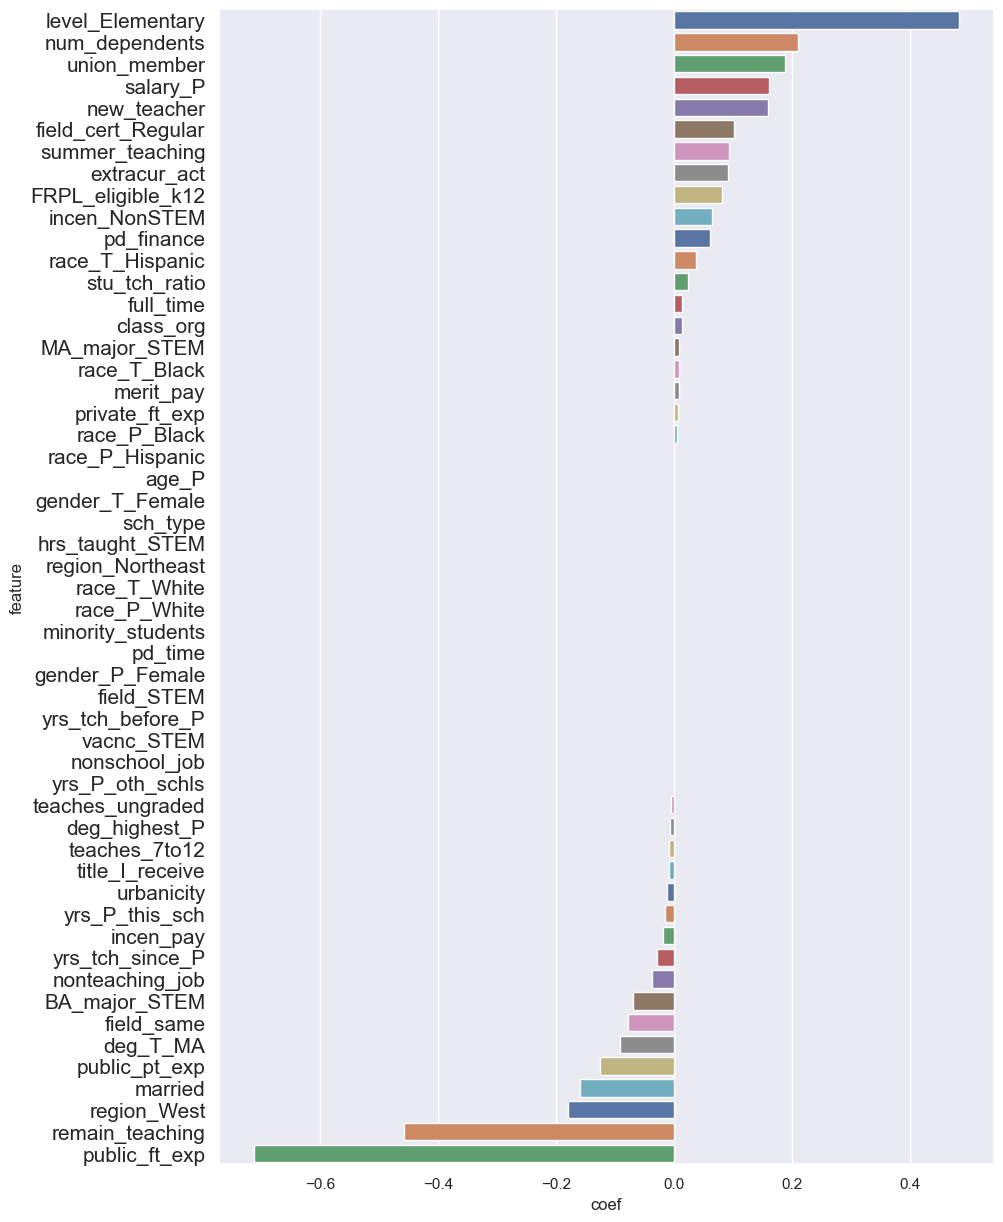

In [13]:
df_lasso2 = df_lasso2.sort_values(by=['coef'], ascending=False)
sns.set(rc={'figure.figsize':(10, 15)})
g=sns.barplot(data=df_lasso2, y="feature", x="coef", palette="deep", orient="h")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, size=20)
g.set_yticklabels(g.get_yticklabels(), size=15)
plt.show()

### Random Forest Feature Importance ###

Train Score: 1.00
Test Score: 0.76


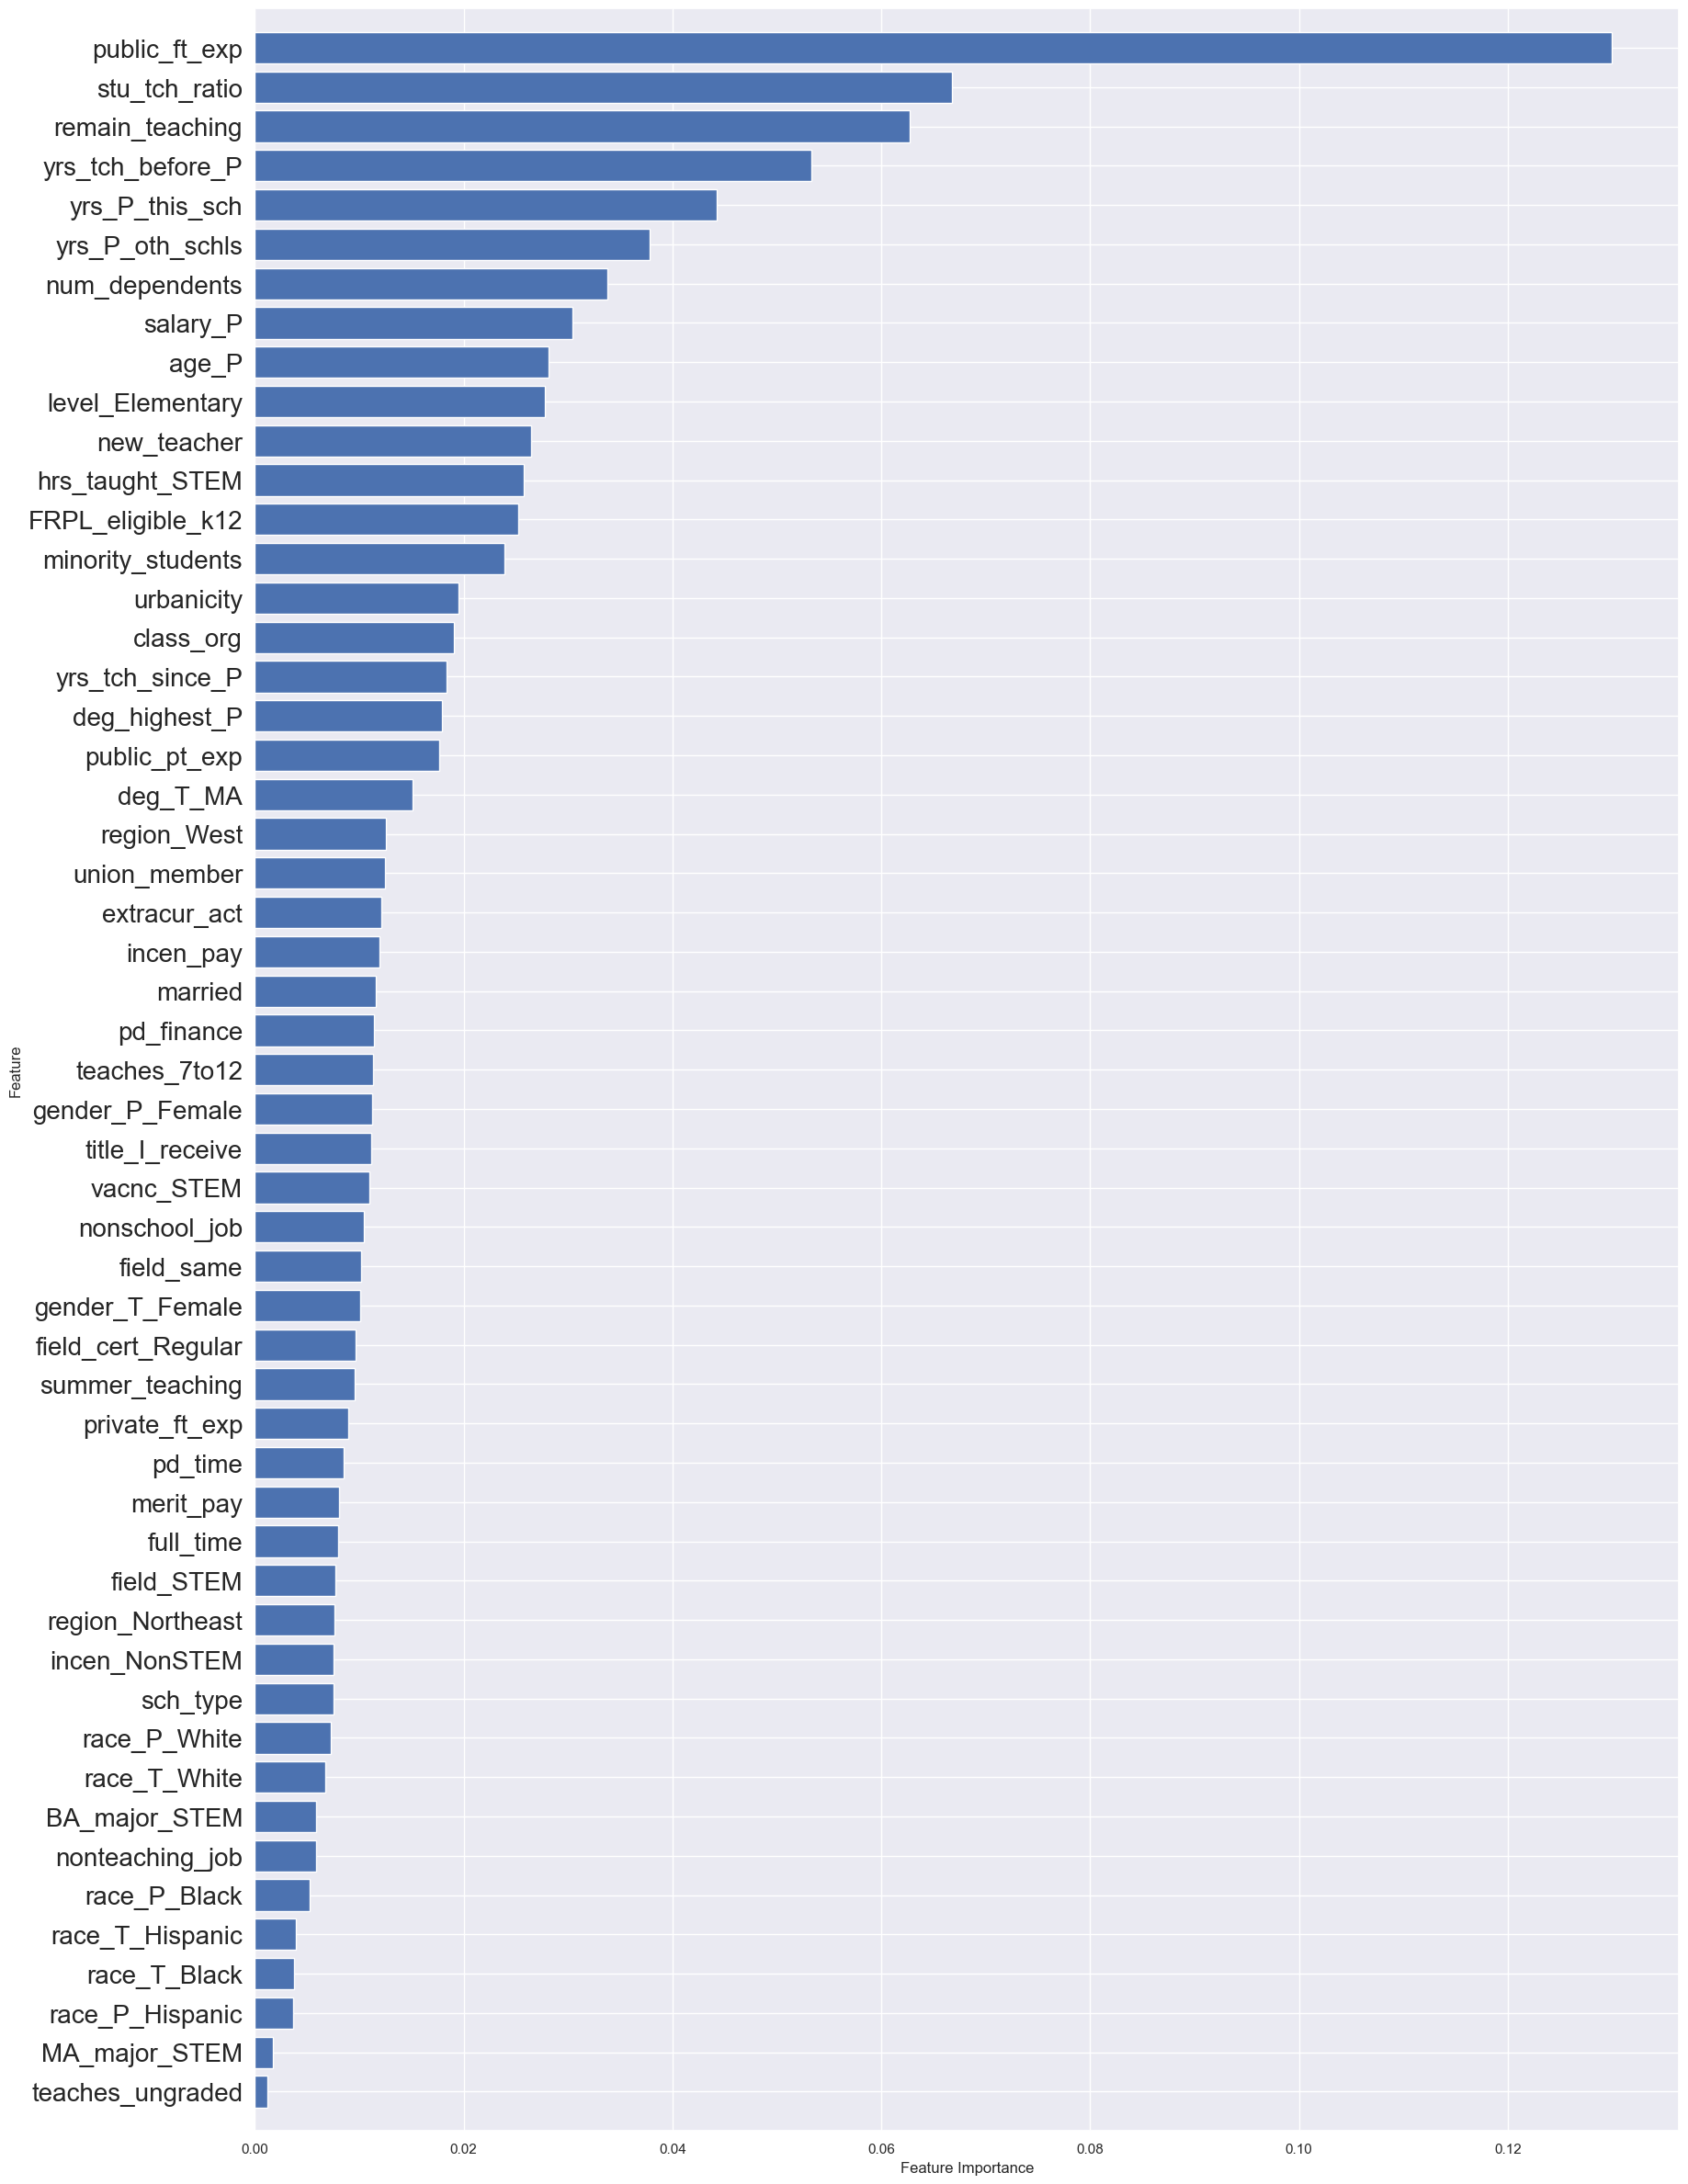

In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.show()

temp = pd.DataFrame({'feature': columns, 
                        'method': 'Feature Importance',
                        'model': 'Random Forest', 
                        'importance': importances})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Random Forest

Train Score: 1.00
Test Score: 0.76


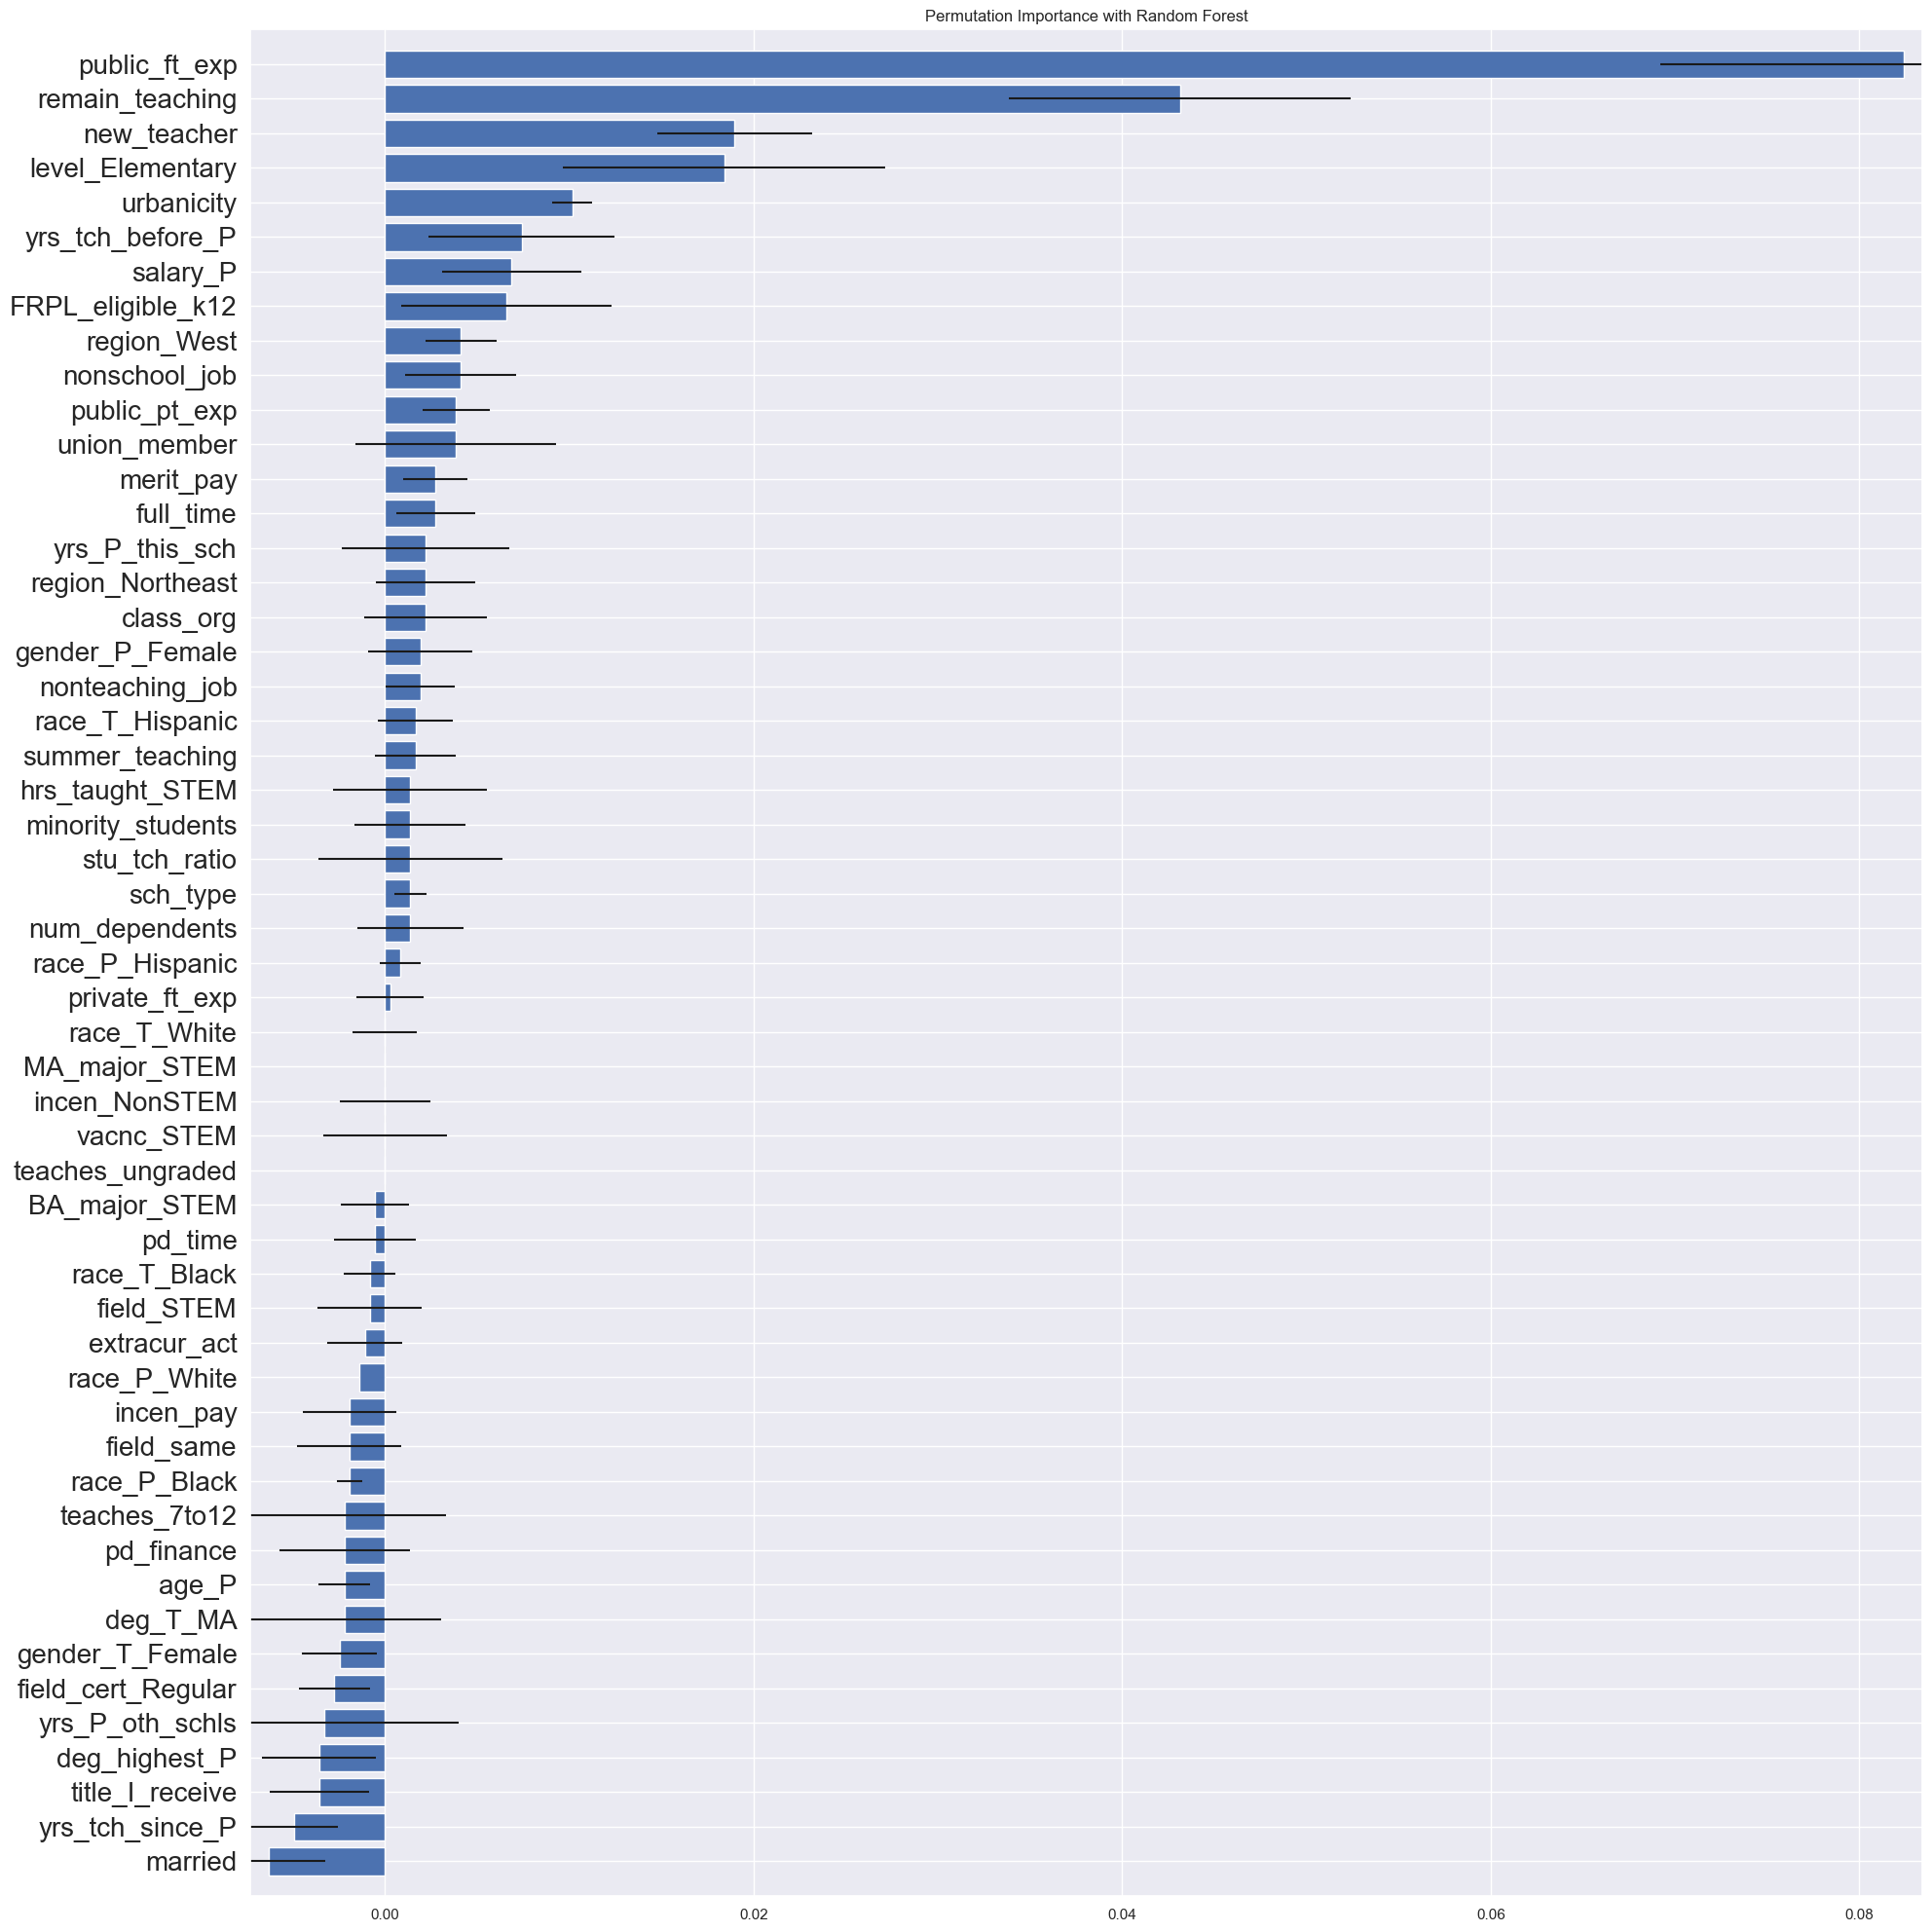

CPU times: user 2.1 s, sys: 2.49 s, total: 4.58 s
Wall time: 3.48 s


In [15]:
%%time
from sklearn.inspection import permutation_importance

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Random Forest")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Random Forest', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Ridge Regression

Train Score: 0.73
Test Score: 0.75


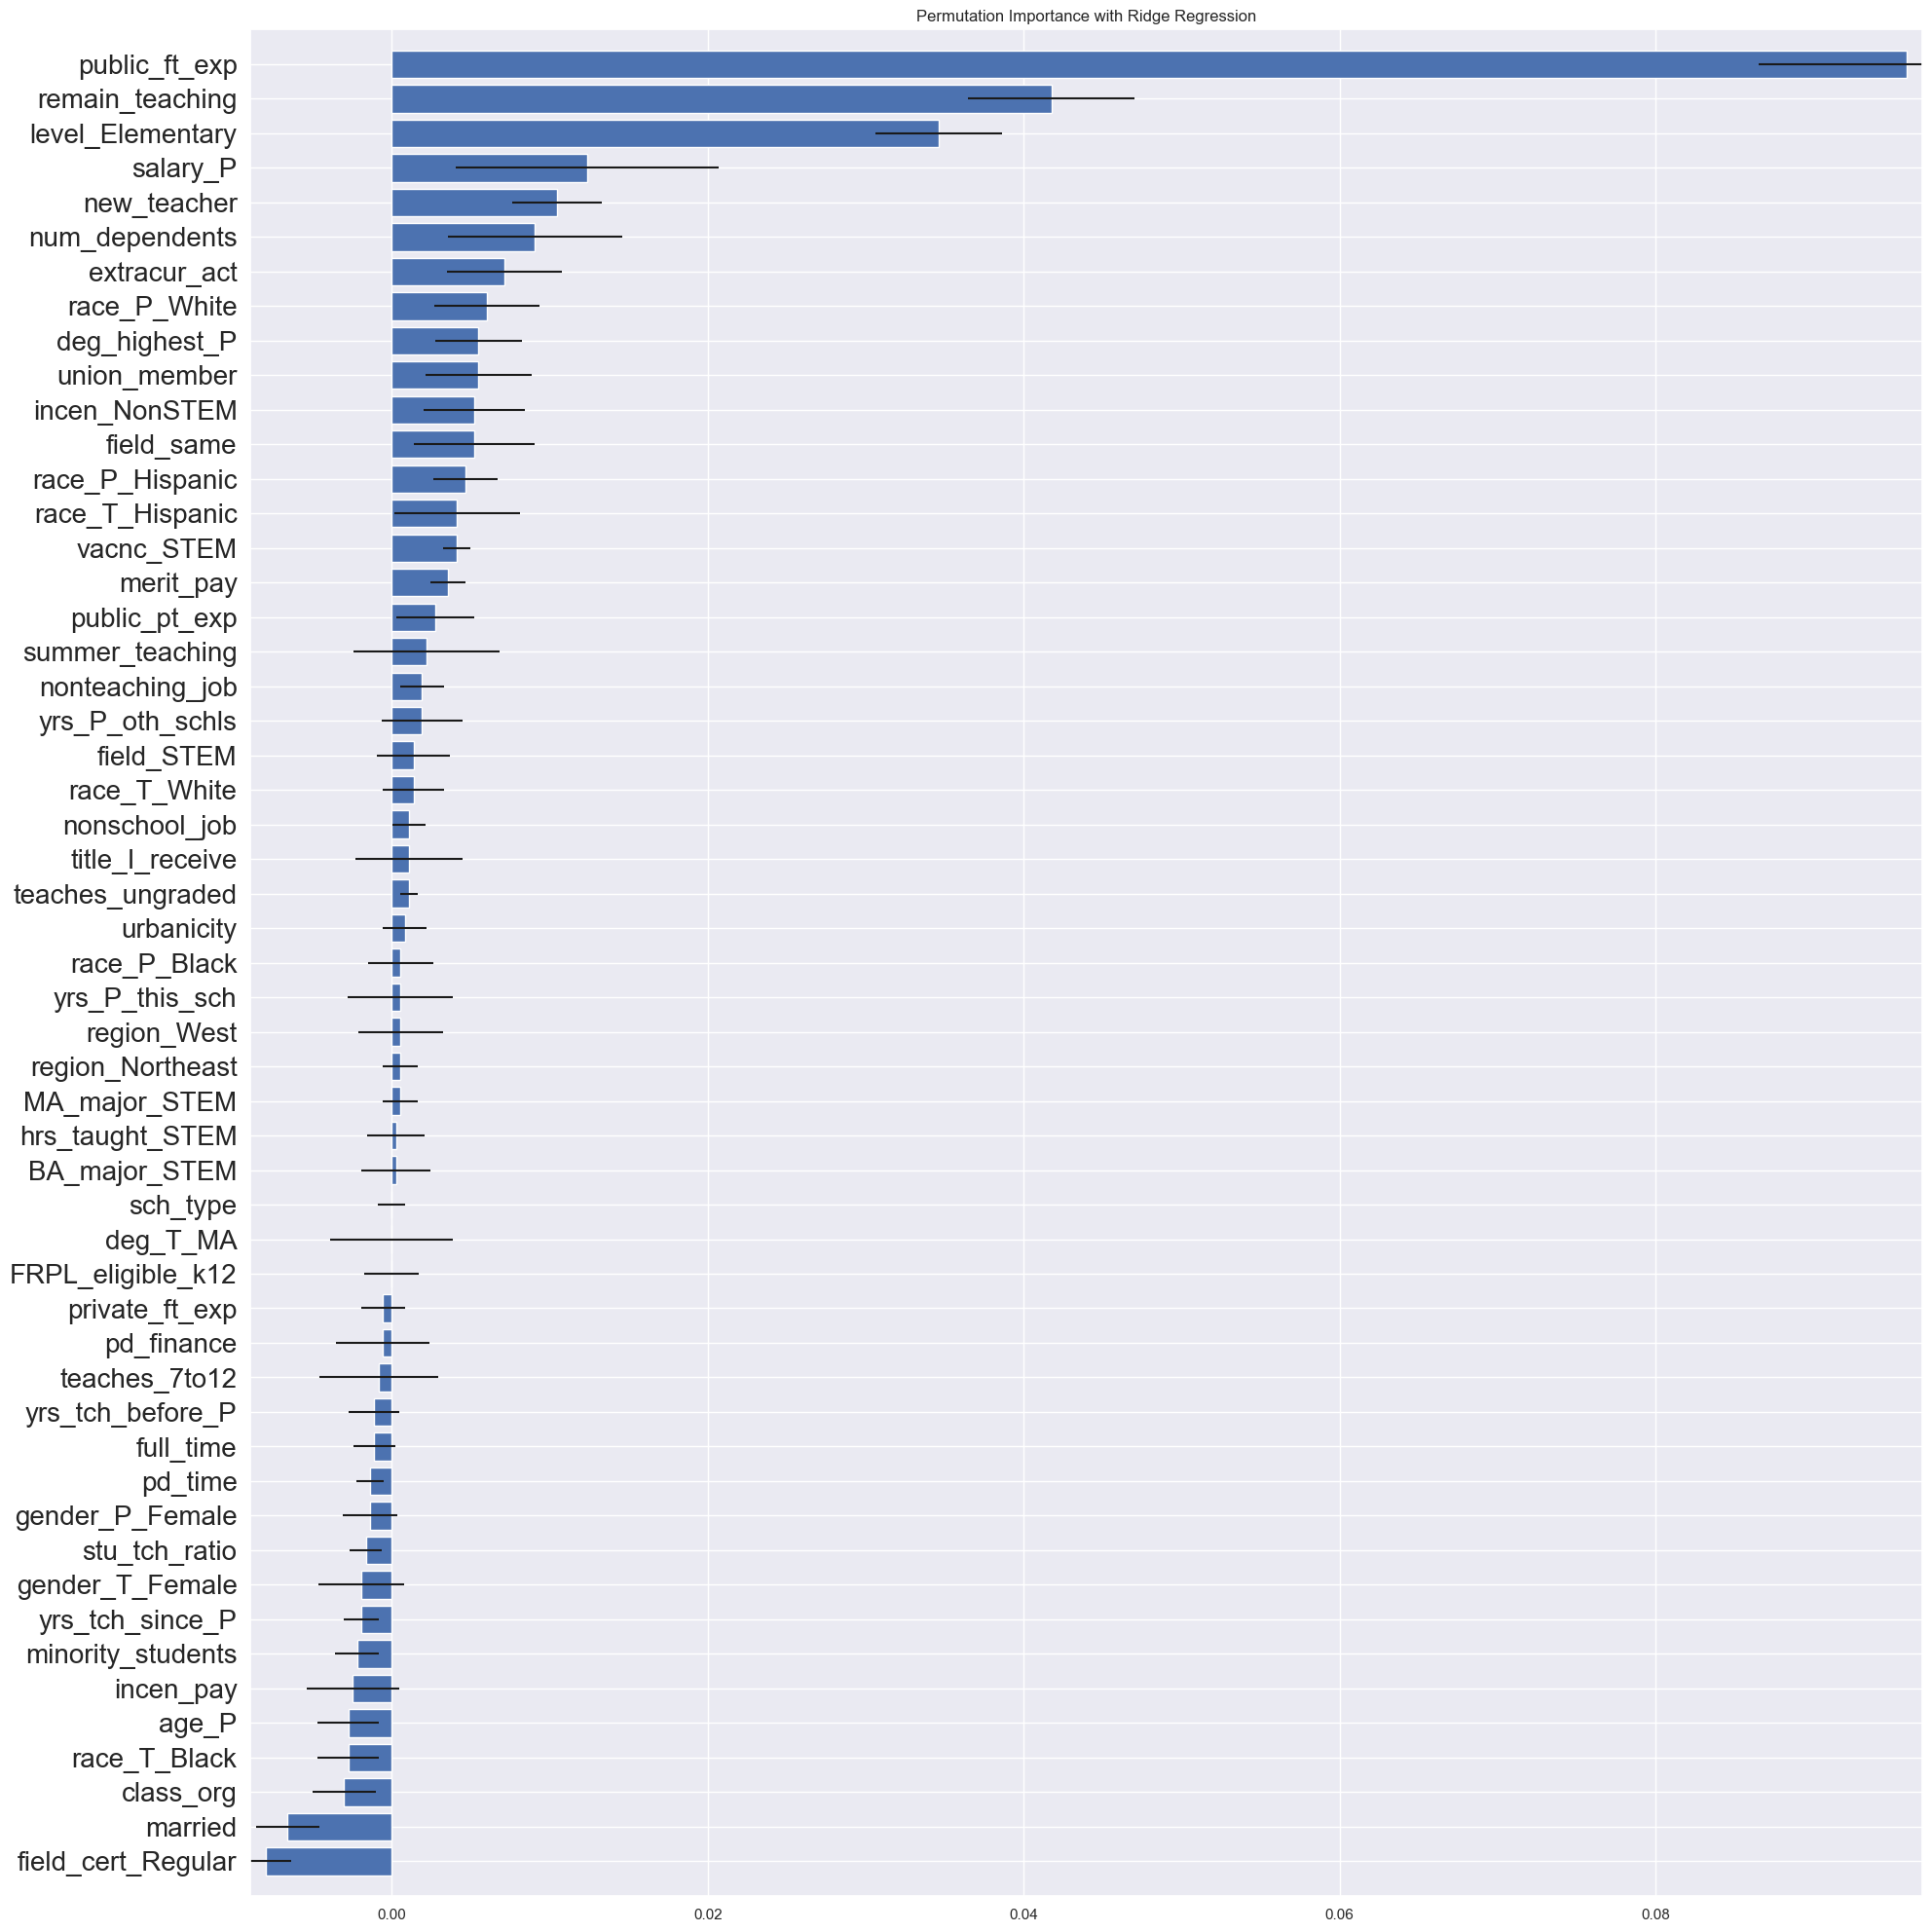

CPU times: user 1.15 s, sys: 1.74 s, total: 2.89 s
Wall time: 489 ms


In [16]:
%%time
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Ridge Regression")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Ridge', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Recursive Feature Elimination(RFE) ###
with Ridge Regression

In [17]:
%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=10, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected: ', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs
Train Score: 0.73
Test Score: 0.75
n Selected:  18
Selected Feature:  Index(['num_dependents', 'region_West', 'married', 'summer_teaching',
       'extracur_act', 'union_member', 'BA_major_STEM', 'field_cert_Regular',
       'deg_T_MA', 'remain_teaching', 'public_ft_exp', 'public_pt_exp',
       'field_same', 'new_teacher', 'FRPL_eligible_k12', 'stu_tch_ratio',
       'level_Elementary', 'salary_P'],
      dtype='object')


### Recursive Feature Elimination(RFE) ###
with Random Forest

In [18]:
%time
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=5, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Random Forest', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
Train Score: 1.00
Test Score: 0.76
n Selected: 49
Selected Feature:  Index(['vacnc_STEM', 'num_dependents', 'region_Northeast', 'region_West',
       'married', 'race_T_White', 'gender_T_Female', 'summer_teaching',
       'nonteaching_job', 'nonschool_job', 'extracur_act', 'merit_pay',
       'union_member', 'BA_major_STEM', 'field_cert_Regular', 'deg_T_MA',
       'pd_time', 'pd_finance', 'remain_teaching', 'field_STEM',
       'hrs_taught_STEM', 'public_ft_exp', 'public_pt_exp', 'private_ft_exp',
       'class_org', 'field_same', 'full_time', 'teaches_7to12', 'new_teacher',
       'minority_students', 'FRPL_eligible_k12', 'stu_tch_ratio', 'sch_type',
       'level_Elementary', 'urbanicity', 'title_I_receive', 'age_P',
       'salary_P', 'yrs_P_this_sch', 'yrs_P_oth_schls', 'yrs_tch_before_P',
       'yrs_tch_since_P', 'deg_highest_P', 'race_P_Black', 'race_P_White',
       'race_P_Hispanic', 'gender_P_Female', 'incen

### Sequential Feature Selection(SFS) ###
with KNN

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'KNN', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.82
Test Score: 0.65
n Selected: 26
Selected Feature:  Index(['num_dependents', 'married', 'race_T_White', 'race_T_Black',
       'race_T_Hispanic', 'nonteaching_job', 'nonschool_job', 'union_member',
       'BA_major_STEM', 'MA_major_STEM', 'pd_time', 'remain_teaching',
       'field_STEM', 'public_ft_exp', 'public_pt_exp', 'private_ft_exp',
       'teaches_ungraded', 'teaches_7to12', 'new_teacher', 'minority_students',
       'stu_tch_ratio', 'level_Elementary', 'race_P_Black', 'race_P_White',
       'race_P_Hispanic', 'gender_P_Female'],
      dtype='object')


### Sequential Feature Selection(SFS) ###
with Ridge Regression

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.73
Test Score: 0.75
n Selected: 26
Selected Feature:  Index(['region_Northeast', 'race_T_Black', 'race_T_Hispanic',
       'gender_T_Female', 'BA_major_STEM', 'MA_major_STEM',
       'field_cert_Regular', 'pd_time', 'remain_teaching', 'hrs_taught_STEM',
       'public_ft_exp', 'public_pt_exp', 'private_ft_exp', 'class_org',
       'field_same', 'teaches_7to12', 'minority_students', 'stu_tch_ratio',
       'sch_type', 'level_Elementary', 'age_P', 'yrs_P_this_sch',
       'yrs_tch_before_P', 'race_P_White', 'race_P_Hispanic', 'incen_pay'],
      dtype='object')


### Number of Feature Selected ###

In [21]:
results['selected'] = results['importance'].apply(lambda x: 1 if x > 0 else 0)

th_quantile=0.5
th_rf = results[results['method'] == 'Feature Importance']['importance'].quantile(th_quantile)
print('Threshold for Random Forest Feature Importance is {:0.4f} at {:0.0f}th percentile'.format(th_rf, th_quantile*100))
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'Feature Importance') & (x.importance < th_rf))
                                                 else x.selected, axis=1)
              
results['Method'] = results.apply(lambda x: 'Variance Threshold' if x.method == 'Variance Threshold'
                                                                 else str(x.method) + " - " + str(x.model), axis=1)

Threshold for Random Forest Feature Importance is 0.0114 at 50th percentile


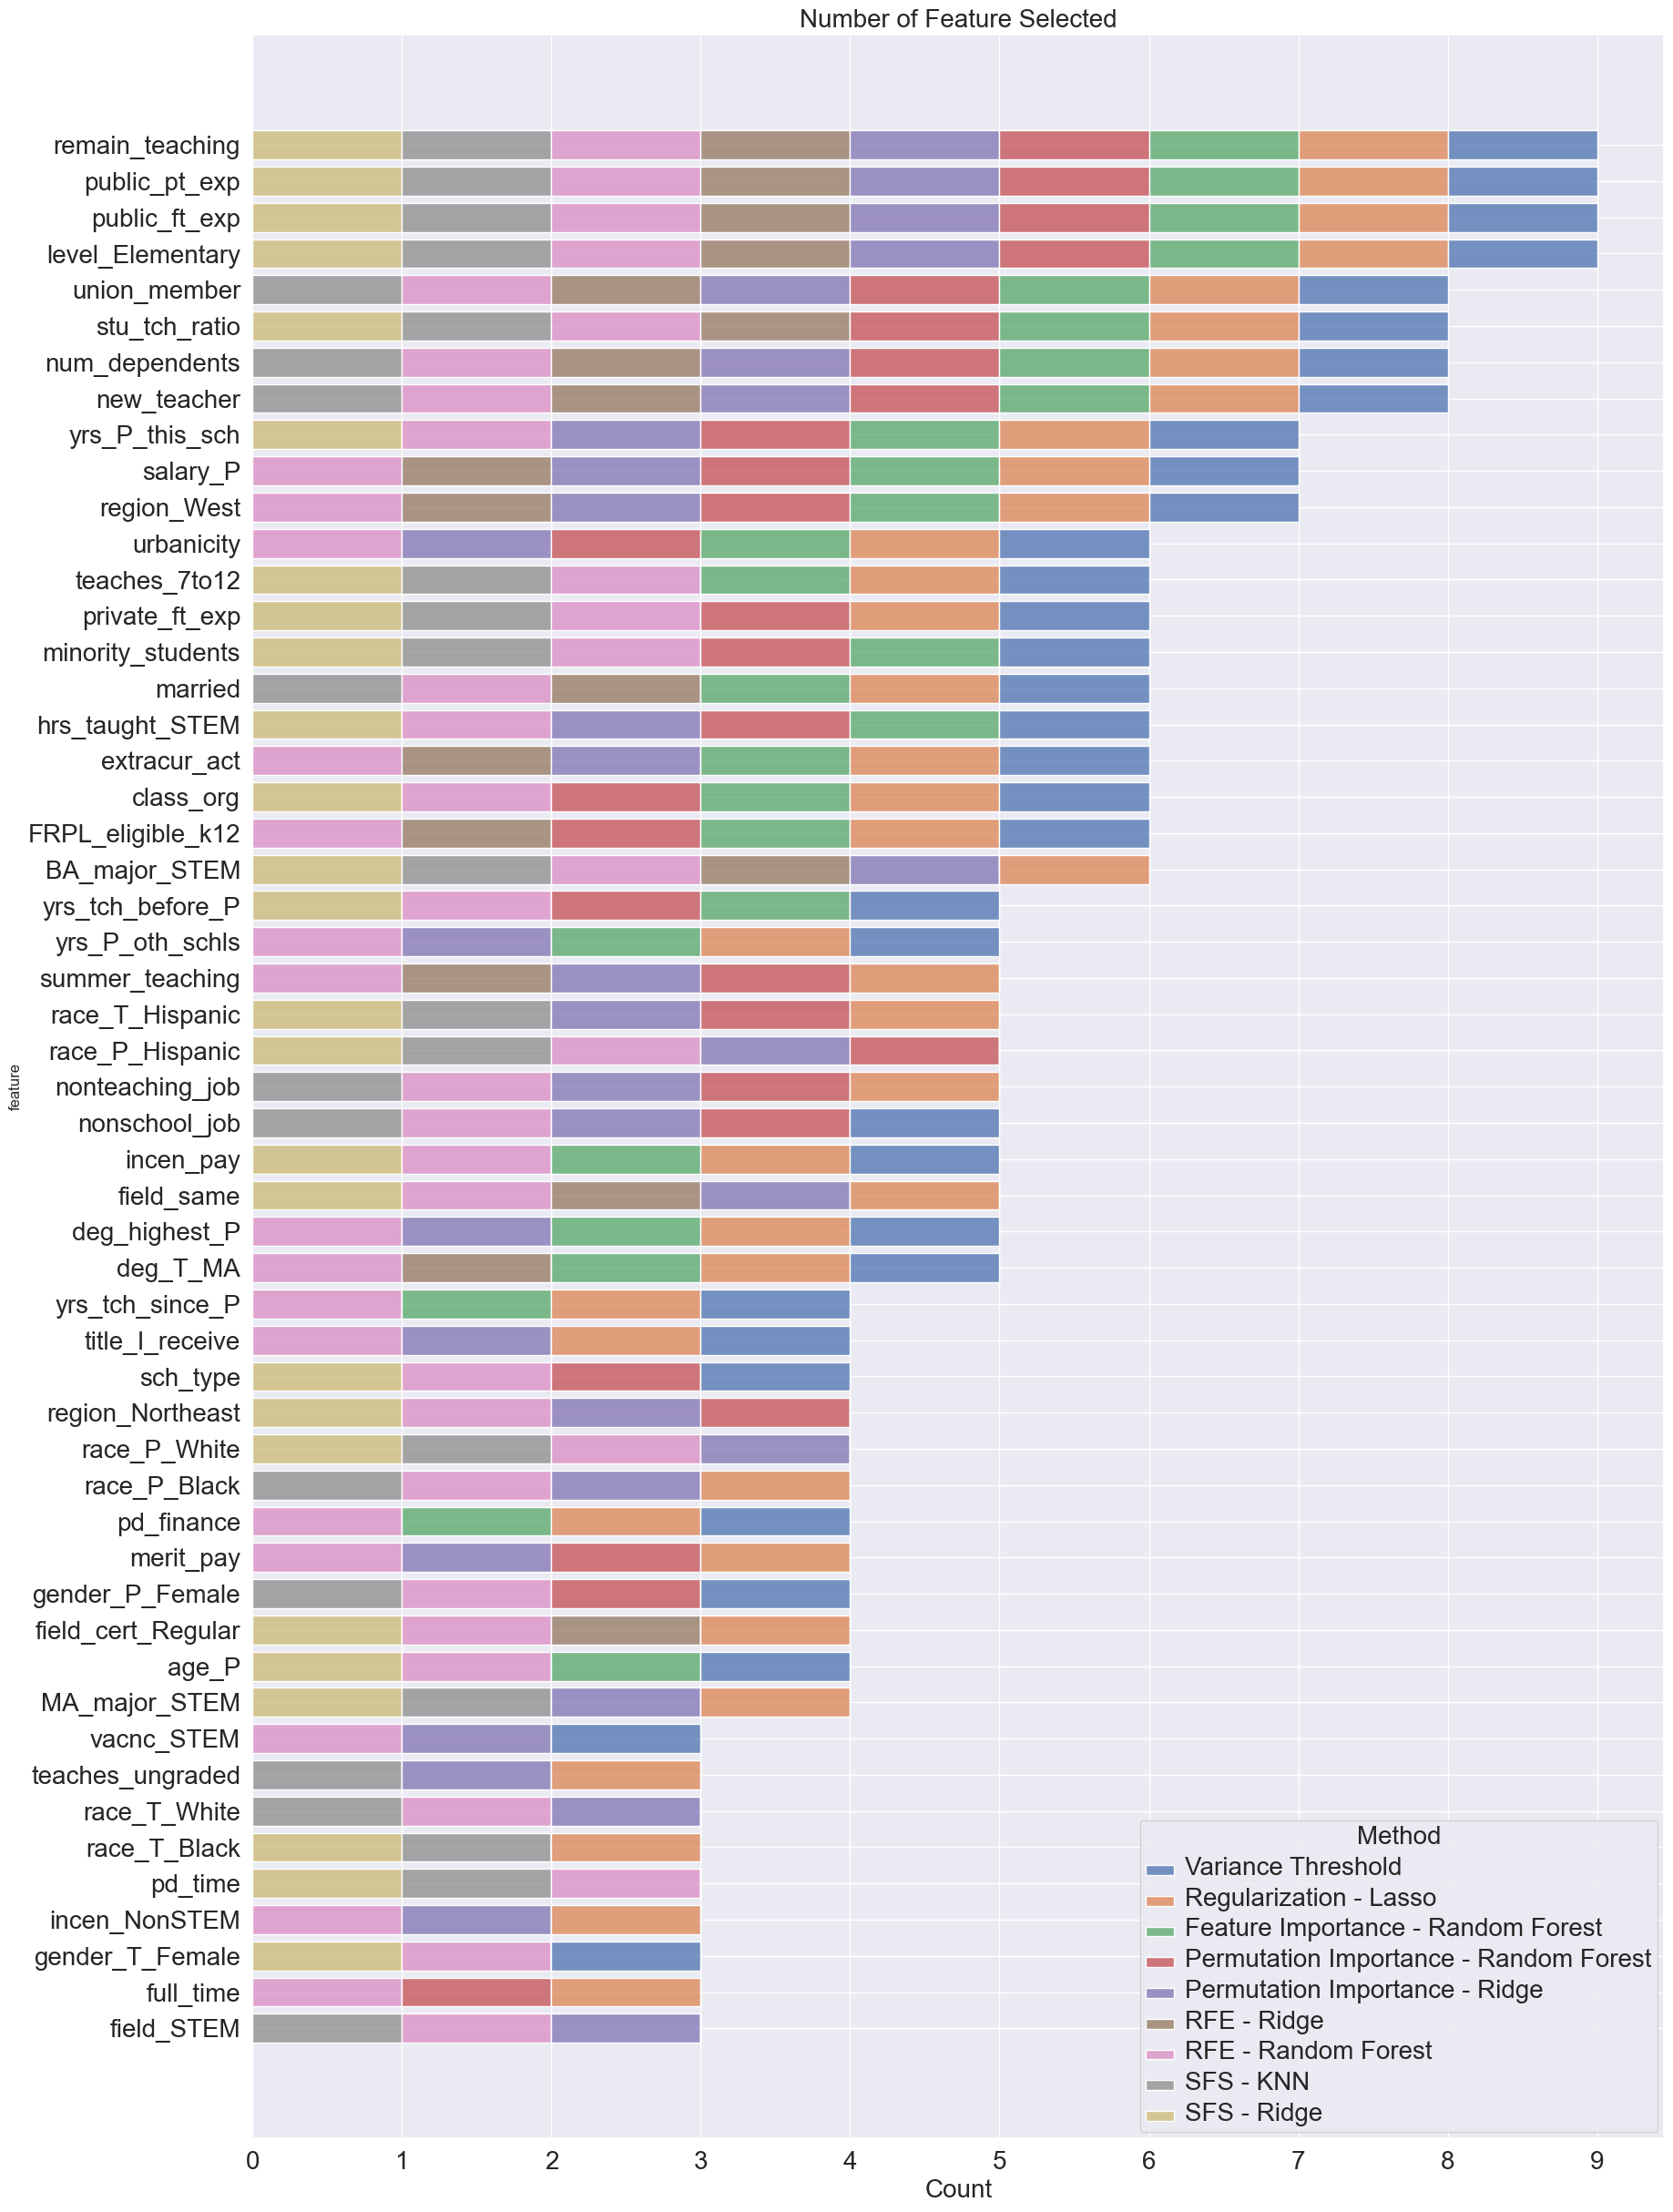

In [22]:
sns.set(rc={'figure.figsize':(20,30)})

data = results[results['selected'] == 1].copy()
data['count']=data.groupby('feature').transform(lambda x: x.sum())['selected']
data = data.sort_values(by=['count', 'feature'], ascending=False)

g = sns.histplot(data=data, y='feature', hue='Method', multiple='stack', shrink=0.8, legend=True)
plt.title('Number of Feature Selected', size=20)
plt.xlabel('Count', size=20)
plt.xticks(range(len(data['Method'].unique())+1), list(range(len(data['Method'].unique())+1)), size=20)
plt.yticks(range(len(data.feature.unique())), data.feature.unique(), size=20)
# plt.legend(fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='20')
plt.setp(g.get_legend().get_title(), fontsize='20') 
plt.show()

In [23]:
vote_result = data.groupby(['feature'], as_index=False).agg({'count': 'count'})
vote_result = vote_result.sort_values(by=['count', 'feature'], ascending=[False, True])
vote_result['category'] = vote_result['feature'].map(lambda x: list_vars[list_vars['new_name']==x]['Category'].values[0])
vote_result['component'] = vote_result['feature'].map(lambda x: list_vars[list_vars['new_name']==x]['Component'].values[0])

feature_set = vote_result[vote_result['count']>=5]
feature_set

,feature,count,category,component
17,level_Elementary,9,General School,School
28,public_ft_exp,9,Experience,Teacher
29,public_pt_exp,9,Experience,Teacher
38,remain_teaching,9,Satisfaction,Teacher
21,new_teacher,8,Experience,Teacher
24,num_dependents,8,Demographics,Teacher
41,stu_tch_ratio,8,Class Organization,Teacher
46,union_member,8,Working Conditions,Teacher
37,region_West,7,General School,School
39,salary_P,7,Working Conditions,Principal


### Most important Feature Analysis ###

In [24]:
most_important_features = feature_set[feature_set['count']==max(feature_set['count'])]['feature'].to_list()
most_important_features

['level_Elementary', 'public_ft_exp', 'public_pt_exp', 'remain_teaching']

**`level_Elementary`: School level based on school reported grade levels offered.**

In [25]:
df['Label'] = df['label_Current'].map(lambda x: 'Current' if x==1 else 'Former')
df['School Level'] = df['level_Elementary'].map(lambda x: 'Elementary' if x==1 else 'Secondary/Combined')

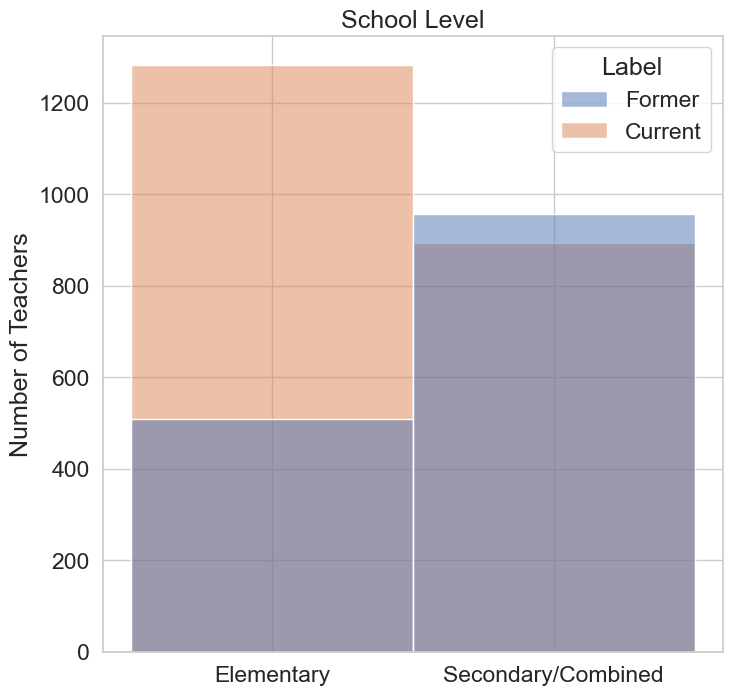

In [30]:
sns.set(rc={'figure.figsize':(8,8)}, style="whitegrid", font_scale=1.5)

g=sns.histplot(data=df, x='School Level', hue='Label')
g.set(title='School Level', xlabel='', ylabel='Number of Teachers')
plt.show()

**`public_ft_exp`, `public_pt_exp`: Teacher's full-time/part-time teaching status at SASS school.**

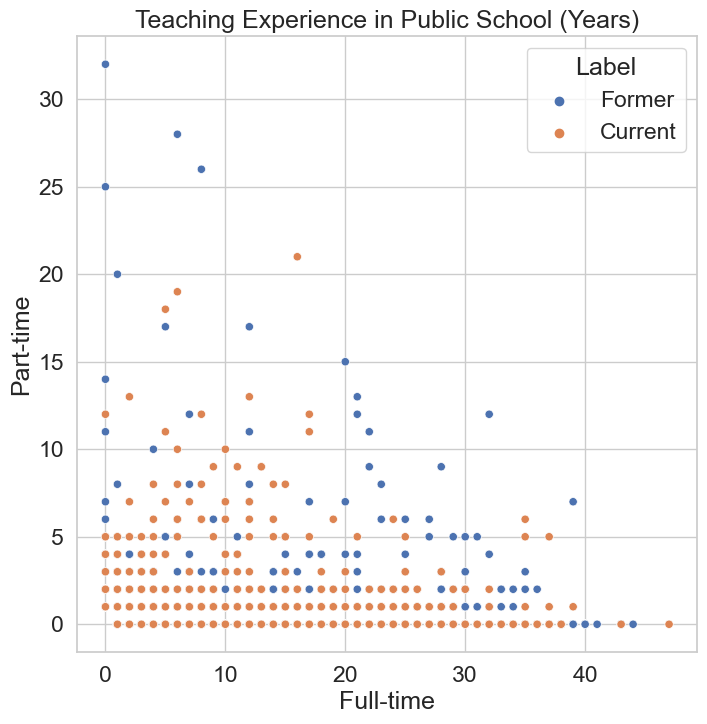

In [27]:
sns.set(rc={'figure.figsize':(8,8)}, style="whitegrid", font_scale=1.5)

g=sns.scatterplot(data=df, x='public_ft_exp', y='public_pt_exp', hue='Label')
g.set(title='Teaching Experience in Public School (Years)', xlabel='Full-time', ylabel='Part-time')
plt.show()

**`remain_teaching`: "How long do you plan to remain in teaching?"**

In [28]:
df['Remain in Teaching']= df['remain_teaching'].map({1: '1: As long as I am able', 
                                                     2: '2: Until I am eligible for retirement', 
                                                     3: '3: Will probably continue unless something better comes along',
                                                     4: '4: Definitely plan to leave teaching as soon as I can',
                                                     5: '5: Undecided at this time'})

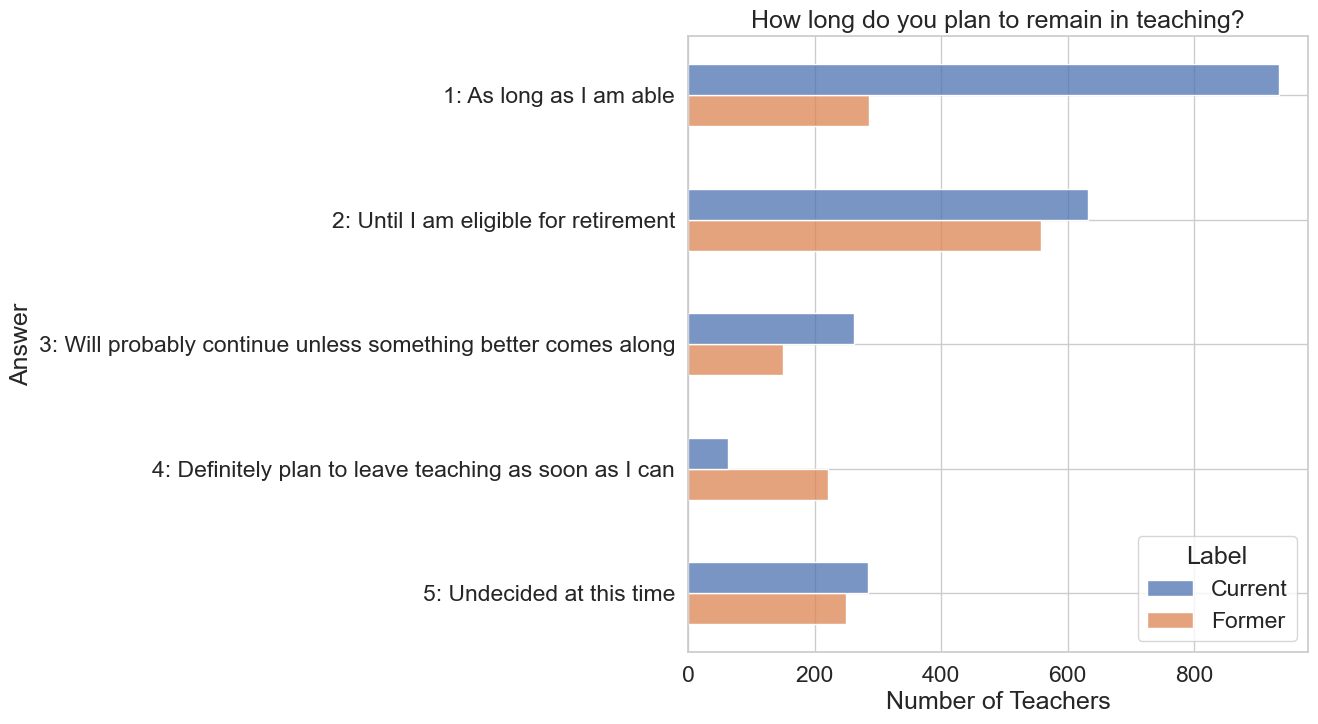

In [29]:
sns.set(rc={'figure.figsize':(8,8)}, style="whitegrid", font_scale=1.5)

g=sns.histplot(data=df.sort_values(by=['remain_teaching']), hue='Label', y='Remain in Teaching', multiple='dodge', shrink=.5)
g.set(title='How long do you plan to remain in teaching?', xlabel='Number of Teachers', ylabel='Answer')
plt.show()